# Comarison between EMCWF and EPC 15 

Note that:
    1. Comaprison is performed on the years 2018 and 2019
    2. Imerg dataset is regridded to resolution from ECMWF ensemble
    3. EPC 15 is computed on regridded Imerg dataset
    4. Evaluation based on regridded Imerg dataset


Scripts to download and process ECMWF data and to regrid Imerg data can be found in folder [scripts_download&prepare_data](scripts_download&prepare_data). 

For CRPS of EPC 15 run **crps_year2019_window.py** on regridded Imerg dataset and for CRPS of ECMWF ensemble run **crps_ecmwf.py**

In [1]:
import numpy as np
import xarray as xr
import xskillscore as xs
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from cartopy import config
import cartopy.crs as ccrs
import matplotlib.patches as patches
import matplotlib.colors

from scipy.stats import norm

In [2]:
dirpath_ecmwf = '' 
dirpath_epc15_= '' 

In [3]:
crps_ecmwf_19 = xr.open_dataset(dirpath_ecmwf+'crps_ecmwf_2019.nc')
crps_ecmwf_18 = xr.open_dataset(dirpath_ecmwf+'crps_ecmwf_2018.nc')

crps_ecmwf_19 = crps_ecmwf_19.rename({'__xarray_dataarray_variable__':'precipitationCal'})
crps_ecmwf_18 = crps_ecmwf_18.rename({'__xarray_dataarray_variable__':'precipitationCal'})

crps19_15 = xr.open_mfdataset(dirpath_epc+'regridcrps2019_15_*.nc4', concat_dim='time', combine='by_coords')
crps19_15 = crps19_15.assign_coords(time=crps_ecmwf_19.time.values)
crps19_15 = crps19_15.transpose('time', 'lat', 'lon')

lat = crps19_15.lat.values
lon = crps19_15.lon.values

crps18_15 = xr.open_mfdataset(dirpath_epc+'regridcrps2018_15_*.nc4', concat_dim='time', combine='by_coords')
crps18_15 = crps18_15.assign_coords(time=crps_ecmwf_18.time.values)
crps18_15 = crps18_15.transpose('time', 'lat', 'lon')

In [7]:
# combine 2018 and 2019 
crps_ecmwf = xr.concat([crps_ecmwf_19, crps_ecmwf_18], dim='time') 
crps_15 = xr.concat([crps19_15, crps18_15], dim='time')

In [8]:
# compute overall mean
print(crps_15.mean().precipitationCal.values)
print(crps_ecmwf.mean().precipitationCal.values)

2.4903605348085986
3.2775182837872765


Since forecast performance strongly depends on annual precipitation amount different regions are investigated seperatly:
    1. South America: (10N,12.5S,82.5W,52.5W)
    2. Central Africa: (5N,15S, 12.5E, 35E)
    3. North Africa: (18.75N,31N,17.5W, 40E)
    4. Australia: (35S, 20.25S, 110E, 144.75E)
Perform a DM test for regions with high annual precipitation amount: South America and Central Africa

In [6]:
# Compute annual precipitation amount
ds = xr.open_dataset('imergall.nc4')
timeyear = ds.groupby('time.year').sum('time')
sumyears = timeyear.sel(year=np.arange(2001,2020))
sumyears_mean = out.mean('year')
precip = sumyears_mean.precipitationCal.values

landsea = xr.open_dataset('GPM_IMERG_LandSeaMask.2.nc4')
landsea2 = np.where(landsea.landseamask[:,500:1300].values<100,1,0)
indx_ls = np.where(landsea2 == 0)

# precipitation amount is divided into 11 different classes
ind1 = np.where(np.logical_and(precip>=0, precip<=25))
ind2 = np.where(np.logical_and(precip>25, precip<=50))
ind3 = np.where(np.logical_and(precip>50, precip<=75))
ind4 = np.where(np.logical_and(precip>75, precip<=100))
ind5 = np.where(np.logical_and(precip>100, precip<=150))
ind6 = np.where(np.logical_and(precip>150, precip<=250))
ind7 = np.where(np.logical_and(precip>250, precip<=400))
ind8 = np.where(np.logical_and(precip>400, precip<=800))
ind9 = np.where(np.logical_and(precip>800, precip<=1200))
ind10 = np.where(np.logical_and(precip>1200, precip<=2000))
ind11 = np.where(np.logical_and(precip>2000, precip<=3000))
ind12 = np.where(precip > 3001)

precip[ind1] = 0
precip[ind2] = 1
precip[ind3] = 2
precip[ind4] = 3
precip[ind5] = 4
precip[ind6] = 5
precip[ind7] = 6
precip[ind8] = 7
precip[ind9] = 8
precip[ind10] = 9
precip[ind11] = 10
precip[ind12] = 11

# sea is assigned
precip[indx_ls] = -1

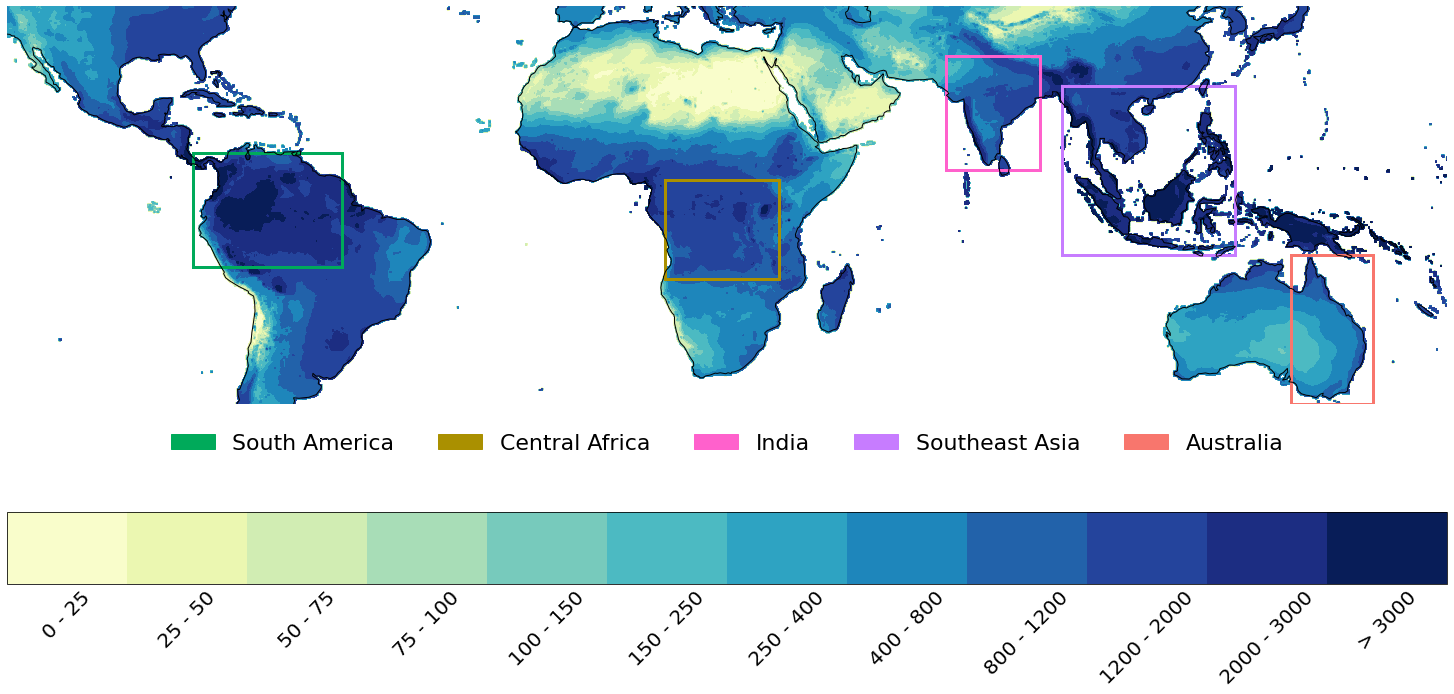

In [7]:
# Plot annual precipitation amount and boxes 
lat_s = sumyears_mean.lat.values
lon_s = sumyears_mean.lon.values

precip_plot = np.transpose(precip)

col_gradient = cm.get_cmap('YlGnBu', 24)
newcolors = col_gradient(np.linspace(0, 1, 24))

newcolors2 = newcolors[::-1]
newcmp = ListedColormap(newcolors)

fig, ax = plt.subplots(2,1,figsize=(20,10))
ax1 = plt.axes(projection=ccrs.PlateCarree())
cf = plt.contourf(lon_s, lat_s, precip_plot, np.arange(-0.5,12,1), cmap=newcmp)
ax1.coastlines()
ax1.set_ylim(-40,40)
ax1.set_xlim(-120,170)

cb = fig.colorbar(cf,orientation='horizontal')
labels = np.arange(-1,12, 1)
loc = labels 
cb.set_ticks(loc)
lables_n = ['0 - 25', '25 - 50','50 - 75','75 - 100','100 - 150','150 - 250','250 - 400','400 - 800','800 - 1200','1200 - 2000','2000 - 3000','> 3000']
cb.set_ticklabels(lables_n)
cb.ax.tick_params(labelsize=20) 
cb.ax.set_xticklabels(lables_n, rotation=45)
cb.ax.tick_params(size=0)

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

 
rect = patches.Rectangle((138.5,-40),16.5,30,linewidth=3,edgecolor='#F8766D',facecolor='none')
ax1.add_patch(rect)
rect = patches.Rectangle((-82.5,-12.5),30,23,linewidth=3,edgecolor='#00AA5A',facecolor='none')
ax1.add_patch(rect)
#rect = patches.Rectangle((-17.5,18.75),58,12.5,linewidth=5,edgecolor='#FF61CC',facecolor='none')
#ax1.add_patch(rect)
rect = patches.Rectangle((69,7),19,23,linewidth=3,edgecolor='#FF61CC',facecolor='none')
ax1.add_patch(rect)
rect = patches.Rectangle((12.5,-15),23,20,linewidth=3,edgecolor='#AA9000',facecolor='none')
ax1.add_patch(rect)
rect = patches.Rectangle((92.5,-10),34.75,34,linewidth=3,edgecolor='#C77CFF',facecolor='none')
ax1.add_patch(rect)

labels = ['South America', 'Central Africa', 'India', 'Southeast Asia', 'Australia']
colors = ["#00AA5A", "#AA9000", "#FF61CC","#C77CFF", "#F8766D"]
#F8766D
#EA4C3B
patches_list = [
    patches.Patch(color=color, label=label)
    for label, color in zip(labels, colors)]
ax1.legend(patches_list, labels, loc='center',ncol=5, frameon=False, bbox_to_anchor=(0.5, -0.1), prop={'size': 22})
plt.axis('off')
plt.savefig("accum_precip_world_boxes.pdf",bbox_inches = 'tight', pad_inches = 0)

In [9]:

landsea_ecmwf = xr.open_dataset('C:/Users/walz/Documents/Work/Promotion/EPC/additional/landsea_mars_2019_01_transform2.nc')


def dm_test(lat, lon, alpha=0.05):
    ec1 = crps_ecmwf.sel(lat = lat)
    epc1 = crps_15.sel(lat = lat)
    ec1 = ec1.sel(lon = lon)
    epc1 = epc1.sel(lon = lon)
    testval = teststatistic(epc1, ec1)
    dimspace = len(lat)*len(lon)
    ds = dimspace/100 
    p1 = norm.cdf(testval)
    p2 = 1-norm.cdf(testval)
    pval = 2 * np.minimum(p1, p2)   
    comparison = (np.sort(pval.flatten()) <= np.arange(1,(dimspace+1))*alpha/(dimspace))

    if any(x == False for x in comparison):
        sign_percent = (np.min(np.where(comparison==False)))/(ds)  
    else:
        sign_percent = 100
        
    indxpval = np.argsort(pval.flatten())
    rejectval = np.repeat(np.array([1, 0]), (sign_percent*ds, len(comparison)-sign_percent*ds))
    a = np.column_stack((rejectval,indxpval))
    a = a[a[:,1].argsort()]
    a2 = np.where(a[:,0] == 1)
    testvalflt = testval.flatten()
    sup_percent = np.round(np.sum(testvalflt[a2] < 0)/ds,2)
    
    info = 'Significantly different at'
    print(info, np.round(sign_percent,2), '% of locations. EPC 15 viewed superior at', sup_percent, '% of locations')

    
def teststatistic(epc1, epc2):
    Smean_F = epc1.mean(dim="time")
    Smean_G = epc2.mean(dim="time")
    difference = np.subtract(Smean_F,Smean_G)
    factor = np.sqrt(2*365)
    variance = np.square(np.subtract(epc1,epc2)).mean(dim="time")
    sigma = np.sqrt(variance)
    teststatistic = factor*np.divide(difference, sigma)
    tt = teststatistic.precipitationCal.values
    return(tt)    

def dm_test_land(lat, lon, alpha=0.05):
    ec1 = crps_ecmwf.sel(lat = lat)
    epc1 = crps_15.sel(lat = lat)
    ec1 = ec1.sel(lon = lon)
    epc1 = epc1.sel(lon = lon)
    testval = teststatistic(epc1, ec1)
    ls_ecmwf = landsea_ecmwf.sel(latitude = lat)
    ls_ecmwf = ls_ecmwf.sel(longitude = lon)
    ls_mask = ls_ecmwf.lsm[0,:,:].values
    ls_mask_indx = np.where(ls_mask.flatten() > 0.5)[0]
    
    testval = testval.flatten()[ls_mask_indx]

    dimspace = len(testval)
    ds = dimspace/100 
    
    p1 = norm.cdf(testval)
    p2 = 1-norm.cdf(testval)
    pval = 2 * np.minimum(p1, p2)   
    comparison = (np.sort(pval.flatten()) <= np.arange(1,(dimspace+1))*alpha/(dimspace))

    if any(x == False for x in comparison):
        sign_percent = (np.min(np.where(comparison==False)))/(ds)
    else:
        sign_percent = 100
        
    rejectval = np.repeat(np.array([1, 0]), (sign_percent*ds, len(comparison)-sign_percent*ds))
    indxpval = np.argsort(pval.flatten())
    
    a = np.column_stack((rejectval,indxpval))
    a = a[a[:,1].argsort()]
    a2 = np.where(a[:,0] == 1)
    testvalflt = testval.flatten()
    sup_percent = np.round(np.sum(testvalflt[a2] < 0)/ds,2)
    
    info = 'Significantly different at'
    print(info, np.round(sign_percent,2), '% of locations. EPC 15 viewed superior at', sup_percent, '% of locations')


def mean_box(lat, lon):
    ec1 = crps_ecmwf.sel(lat = lat)
    epc1 = crps_15.sel(lat = lat)
    ec1 = ec1.sel(lon = lon)
    epc1 = epc1.sel(lon = lon)
    print('Mean CRPS for EPC 15:', np.round(epc1.mean().precipitationCal.values,2))
    print('Mean CRPS for ECMWF:', np.round(ec1.mean().precipitationCal.values,2))
    
def mean_land(lata, lona):
    ec1 = crps_ecmwf.sel(lat = lata)
    epc1 = crps_15.sel(lat = lata)
    ec1 = ec1.sel(lon = lona)
    epc1 = epc1.sel(lon = lona) 
    ls_ecmwf = landsea_ecmwf.sel(latitude = lata)
    ls_ecmwf = ls_ecmwf.sel(longitude = lona)
    ls_mask = ls_ecmwf.lsm[0,:,:].values
    # compute mean over time
    ecm = ec1.mean(dim='time').precipitationCal.values
    epcm = epc1.mean(dim='time').precipitationCal.values
    
    ls_mask_indx = np.where(ls_mask.flatten() > 0.5)[0]
    print('Mean CRPS for EPC over land',np.round(np.mean(epcm.flatten()[ls_mask_indx]),2))
    print('Mean CRPS for ECMWF over land',np.round(np.mean(ecm.flatten()[ls_mask_indx]),2))

In [10]:
# 1. South America
southAmlat = lat[110:203]
southAmlon = lon[390:511]

print('Mean values and 2-sided DM test complete box:')
mean_box(southAmlat, southAmlon)
dm_test(southAmlat, southAmlon)
print('Mean values and DM test complete land in box:')
mean_land(southAmlat, southAmlon)
dm_test_land(southAmlat, southAmlon)

Mean values and 2-sided DM test complete box:
Mean CRPS for EPC 15: 4.0
Mean CRPS for ECMWF: 5.17
Significantly different at 98.2 % of locations. EPC 15 viewed superior at 98.2 % of locations
Mean values and DM test complete land in box:
Mean CRPS for EPC over land 4.18
Mean CRPS for ECMWF over land 5.36
Significantly different at 98.16 % of locations. EPC 15 viewed superior at 98.16 % of locations


In [11]:
# 2. Central Africa
midAlat = lat[100:181]
midAlon = lon[770:863]

print('Mean values and 2-sided DM test complete box:')
mean_box(midAlat, midAlon)
dm_test(midAlat, midAlon)
print('Mean values and DM test complete land in box:')
mean_land(midAlat, midAlon)
dm_test_land(midAlat, midAlon)

Mean values and 2-sided DM test complete box:
Mean CRPS for EPC 15: 2.75
Mean CRPS for ECMWF: 3.42
Significantly different at 88.49 % of locations. EPC 15 viewed superior at 88.26 % of locations
Mean values and DM test complete land in box:
Mean CRPS for EPC over land 2.74
Mean CRPS for ECMWF over land 3.4
Significantly different at 88.11 % of locations. EPC 15 viewed superior at 87.87 % of locations


In [12]:
# 3. India
indialat = lat[188:281]
indialon = lon[996:1073]

print('Mean values and 2-sided DM test complete box:')
mean_box(indialat, indialon)
dm_test(indialat, indialon)
print('Mean values and DM test complete land in box:')
mean_land(indialat, indialon)
dm_test_land(indialat, indialon)

Mean values and 2-sided DM test complete box:
Mean CRPS for EPC 15: 2.71
Mean CRPS for ECMWF: 3.17
Significantly different at 54.95 % of locations. EPC 15 viewed superior at 54.95 % of locations
Mean values and DM test complete land in box:
Mean CRPS for EPC over land 2.09
Mean CRPS for ECMWF over land 2.58
Significantly different at 63.8 % of locations. EPC 15 viewed superior at 63.8 % of locations


In [13]:
# 4. Australia
australialat = lat[0:121]
australialon = lon[1274:1341]

print('Mean values and 2-sided DM test complete box:')
mean_box(australialat, australialon)
dm_test(australialat, australialon)
print('Mean values and DM test complete land in box:')
mean_land(australialat, australialon)
dm_test_land(australialat, australialon)

Mean values and 2-sided DM test complete box:
Mean CRPS for EPC 15: 1.73
Mean CRPS for ECMWF: 2.14
Significantly different at 64.72 % of locations. EPC 15 viewed superior at 64.06 % of locations
Mean values and DM test complete land in box:
Mean CRPS for EPC over land 0.98
Mean CRPS for ECMWF over land 1.26
Significantly different at 63.21 % of locations. EPC 15 viewed superior at 62.06 % of locations


In [14]:
# 5. South-east asia
asialat = lat[120:257]
asialon = lon[1090:1230]

print('Mean values and 2-sided DM test complete box:')
mean_box(asialat, asialon)
dm_test(asialat, asialon)
print('Mean values and DM test complete land in box:')
mean_land(asialat, asialon)
dm_test_land(asialat, asialon)

Mean values and 2-sided DM test complete box:
Mean CRPS for EPC 15: 4.24
Mean CRPS for ECMWF: 4.95
Significantly different at 77.82 % of locations. EPC 15 viewed superior at 77.82 % of locations
Mean values and DM test complete land in box:
Mean CRPS for EPC over land 3.95
Mean CRPS for ECMWF over land 4.87
Significantly different at 94.25 % of locations. EPC 15 viewed superior at 94.25 % of locations


# CRPSS of ECMWF relative to EPC 15

In [22]:
diff =(crps_15.mean('time') - crps_ecmwf.mean('time')) / crps_15.mean('time')
vals = diff.precipitationCal.values

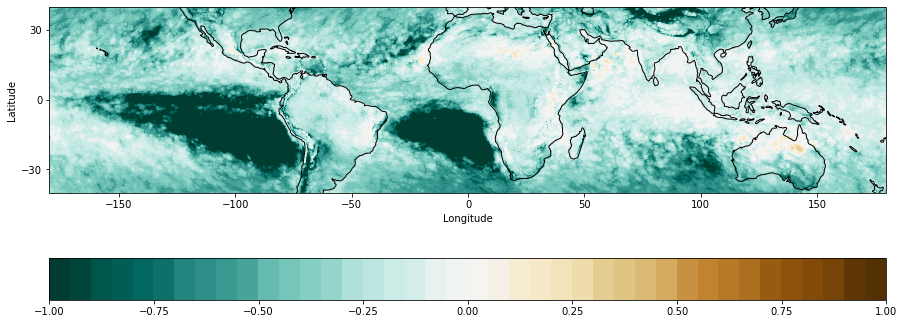

In [24]:
import cartopy

col_gradient = cm.get_cmap('BrBG', 50)
newcolors = col_gradient(np.linspace(0, 1, 50))
newcmp = ListedColormap(newcolors[::-1])

vals_crpss_transform = np.where(vals <-1, -1, vals)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,8), gridspec_kw={'height_ratios': [3, 1]})
ax1 = plt.axes(projection=ccrs.PlateCarree())
cf = plt.contourf(lon, lat, vals_crpss_transform, np.arange(-1,1.01 ,0.05), 
                  cmap = newcmp) 
ax1.coastlines()

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
xt = ax1.set_xticks([-150,-100,-50,0,50,100,150])
yt = ax1.set_yticks([-30,0, 30])
fb = fig.colorbar(cf,orientation='horizontal')